# Customer Churn Prediction

## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

## Exploration

In [44]:
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


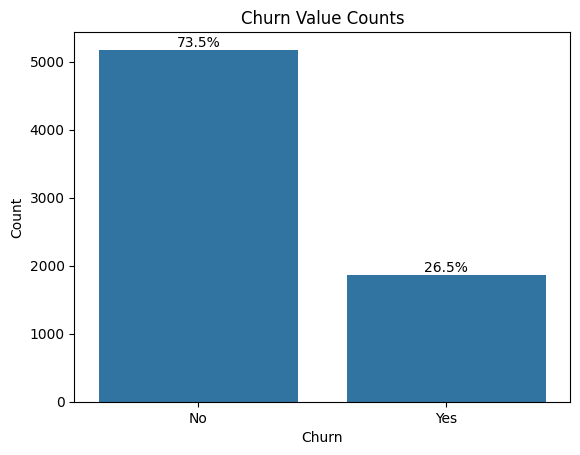

In [45]:
ax = sns.barplot(x=df['Churn'].value_counts().index, y=df['Churn'].value_counts().values)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn Value Counts')

total = df.shape[0]
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

## Data Preprcoessing

In [46]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df = df[~df['Churn'].isna()]

binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype == 'object' and col != 'Churn']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

df = pd.get_dummies(df, drop_first=True)

## Train Test Split

In [ ]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

Model comparison: Logistic Regression, XGBoost, and a simple Neural Network

In [49]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# XGBoost 
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Deep Learning
nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0)
nn_probs = nn_model.predict(X_test_scaled).flatten()
nn_preds = (nn_probs > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Model Evaluation

In [50]:
plt.figure(figsize=(8, 6))

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"{name} Classification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC AUC Score
    auc = roc_auc_score(y_true, y_prob)
    print(f"{name} ROC AUC: {auc:.4f}\n")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

<Figure size 800x600 with 0 Axes>

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1036
           1       0.72      0.32      0.44       373

    accuracy                           0.79      1409
   macro avg       0.76      0.64      0.65      1409
weighted avg       0.78      0.79      0.75      1409



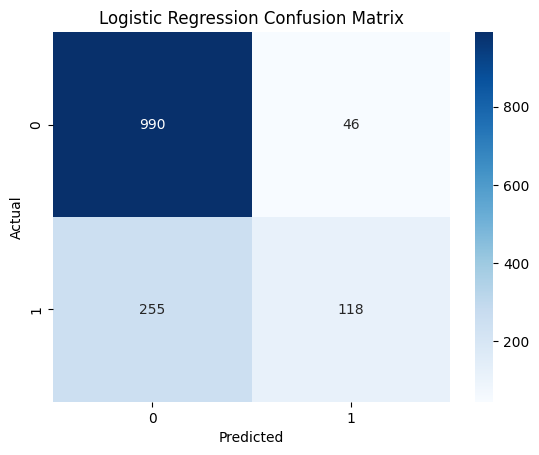

Logistic Regression ROC AUC: 0.8566

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.50      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



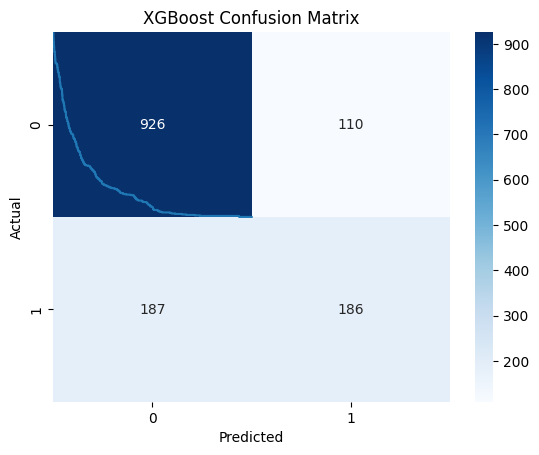

XGBoost ROC AUC: 0.8392

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      1036
           1       0.84      0.14      0.24       373

    accuracy                           0.76      1409
   macro avg       0.80      0.56      0.55      1409
weighted avg       0.78      0.76      0.70      1409



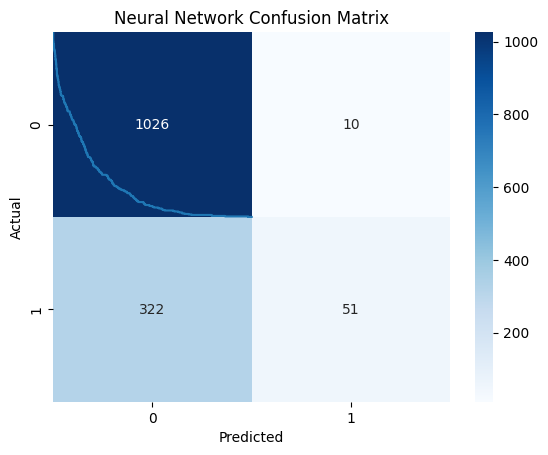

Neural Network ROC AUC: 0.8569

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1036
           1       0.69      0.45      0.54       373

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



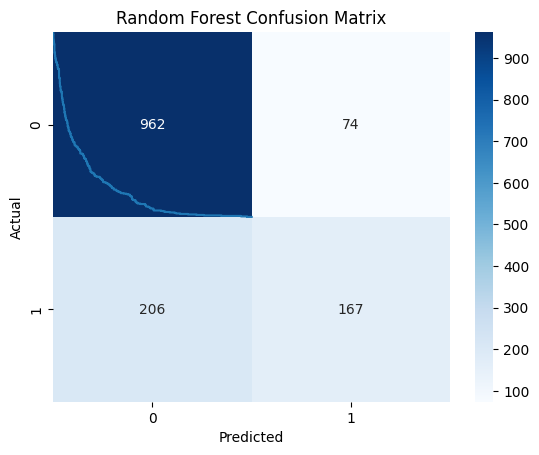

Random Forest ROC AUC: 0.8550



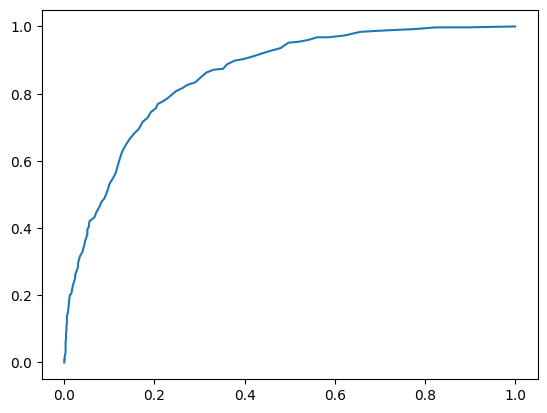

In [51]:
evaluate_model("Logistic Regression", y_test, lr_preds, lr_probs)
evaluate_model("XGBoost", y_test, xgb_preds, xgb_probs)
evaluate_model("Neural Network", y_test, nn_preds, nn_probs)
evaluate_model("Random Forest", y_test, rf_preds, rf_probs)

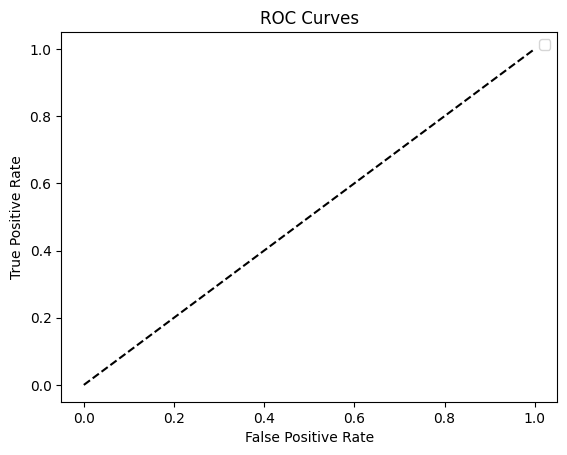

In [52]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## Model Comprarision

In [53]:
from tabulate import tabulate

results = []

for name, preds, probs in [
    ("Logistic Regression", lr_preds, lr_probs),
    ("XGBoost", xgb_preds, xgb_probs),
    ("Neural Network", nn_preds, nn_probs),
    ("Random Forest", rf_preds, rf_probs)
]:
    acc = np.mean(preds == y_test)
    auc = roc_auc_score(y_test, probs)
    results.append([name, acc, auc])

print(tabulate(results, headers=["Model", "Accuracy", "ROC AUC"], floatfmt=".4f"))

Model                  Accuracy    ROC AUC
-------------------  ----------  ---------
Logistic Regression      0.7864     0.8566
XGBoost                  0.7892     0.8392
Neural Network           0.7644     0.8569
Random Forest            0.8013     0.8550


In [54]:
from sklearn.model_selection import cross_val_score

def cv_evaluate(model_name, model, X_data, y_data):
    acc_scores = cross_val_score(model, X_data, y_data, cv=5, scoring='accuracy')
    auc_scores = cross_val_score(model, X_data, y_data, cv=5, scoring='roc_auc')
    print(f"{model_name} CV Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
    print(f"{model_name} CV ROC AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}\n")

cv_evaluate("Logistic Regression", lr_model, X_train_scaled, y_train)
cv_evaluate("XGBoost", xgb_model, X_train_scaled, y_train)
cv_evaluate("Random Forest", rf_model, X_train_scaled, y_train)

Logistic Regression CV Accuracy: 0.7638 ± 0.0118
Logistic Regression CV ROC AUC: 0.8316 ± 0.0105

XGBoost CV Accuracy: 0.7780 ± 0.0091
XGBoost CV ROC AUC: 0.8165 ± 0.0124

Random Forest CV Accuracy: 0.7941 ± 0.0108
Random Forest CV ROC AUC: 0.8320 ± 0.0103



## Prediction

In [ ]:
multi_customers = X.iloc[:5].copy()
multi_customers['MonthlyCharges'] = [50, 70, 90, 110, 130]
multi_customers['tenure'] = [12, 2, 1, 10, 5]

scaled_multi = scaler.transform(multi_customers)
predictions = rf_model.predict(scaled_multi).flatten()

for i, prob in enumerate(predictions):
    print(f"Customer {i+1}: Churn Probability = {prob:.2%}, Predicted Class = {'Churn' if prob > 0.5 else 'No Churn'}")

Customer 1: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 2: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 3: Churn Probability = 100.00%, Predicted Class = Churn
Customer 4: Churn Probability = 0.00%, Predicted Class = No Churn
Customer 5: Churn Probability = 100.00%, Predicted Class = Churn
